In [13]:
import torch
from CNN.models import MlpRegBaseline
from CNN.datasets import Class_Seq_Dataset
from CNN.datasets import load_class_seq_data
import matplotlib.pylab as plt
import os

In [14]:
# useful functions:

def load_model(model_path, plot=False):
    cp = torch.load(model_path, map_location=torch.device("cpu"))
    xval_data = cp["models_data"]
    a = cp["arguments"]

    train_accuracies = torch.tensor([data["train_accuracies"] for data in xval_data])
    validation_accuracies = torch.tensor([data["validation_accuracies"] for data in xval_data])
    test_accuracies = torch.tensor([data["test_accuracies"] for data in xval_data])
    train_accuracies = torch.permute(train_accuracies, (1,0))
    validation_accuracies = torch.permute(validation_accuracies, (1,0))
    test_accuracies = torch.permute(test_accuracies, (1,0))
    if plot:
        #plot mean validation and loss
        plt.figure(figsize=(9,6))
        plt.plot(range(a.epochs), train_accuracies.mean(dim=1))
        plt.plot(range(a.epochs), validation_accuracies.mean(dim=1))
        plt.plot(range(a.epochs), test_accuracies.mean(dim=1))
        plt.title("Valid")
        plt.xlabel("Iterations over dataset")
        plt.ylabel("Accuracy")
        plt.title(f"Mean learning curve of 10 models from \n {os.path.basename(model_path).replace('_', ' ')}")
        plt.legend(["Training", "Validation", "Test"])
        plt.show()

        #plot the actual validation and loss
        plt.figure(figsize=(9,6))
        plt.plot(range(a.epochs), train_accuracies)
        plt.plot(range(a.epochs), validation_accuracies)
        plt.plot(range(a.epochs), test_accuracies)
        plt.title("Validation and losses")
        plt.xlabel("Iterations over dataset")
        plt.show()
    return xval_data, a

def get_rates(xval_data, a):
    csv_peptides, csv_ba_values, groups = load_class_seq_data("../../data/external/processed/BA_pMHCI.csv", a.threshold)
    dataset = Class_Seq_Dataset(csv_peptides, csv_ba_values, a.encoder, torch.device("cpu"))
    accuracies = []
    tpr = []
    fpr = []
    tnr = []
    fnr = []
    nr = []
    pr = []
    for data in xval_data:
        # load the model and data
        input_dimensions = (20*9, 40*9)[a.encoder=="mixed"]
        model = MlpRegBaseline(neurons_per_layer=a.neurons, input=input_dimensions, outputs=2) 
        model.load_state_dict(data["model"])
        model.eval()

        test_X = dataset.peptides[data["test_indices"]]
        test_label = dataset.labels[data["test_indices"]]

        ### MAKE THE PREDICTION ON THE TEST DATASET ###
        with torch.no_grad():
            test_pred_label = model(test_X).max(1)[1]

        ### CALCULATE SENSITIVITY, SPECIFICITY AND OTHER METRICS ###
        # Calculate the confusion tensor (AKA matching matrix) by dividing predictions
        # with true values.
        # To assess performances, first calculate absolute values and adjust it to 
        # the total number of expected postives, negatives:

        # calculate absolute values:
        confusion = test_pred_label/test_label # absolute values for metrics
        tot = test_label.shape[0] # total number of prediction
        pos = float((test_label == 1.).sum()) # total number of positives (truth 1)
        neg = float((test_label == 0.).sum()) # total number of negatives (truth 0)

        # calculate rates:
        tpr.append( float((confusion == 1.).sum()/pos) ) # true positive rate = prediction 1/truth 1
        fnr.append( float((confusion == 0.).sum()/pos)) # false negative rate = predicted 0/truth 1
        tnr.append( float(torch.isnan(confusion).sum()/neg) ) # true negative rate = predicted 0/truth 0
        fpr.append( float((confusion == float("inf")).sum()/neg) ) # false positive rate = predicted 1/truth 0

        # calculate raw accuracy:
        accuracy = float((test_pred_label == test_label).sum()/test_label.shape[0])
        accuracies.append(accuracy)

        # to keep track of truths in test sets
        nr.append( neg/tot ) 
        pr.append( pos/tot )

    ### STORE METRICS ###
    accuracies = torch.tensor(accuracies)
    tpr = torch.tensor(tpr)
    fnr = torch.tensor(fnr)
    tnr = torch.tensor(tnr)
    fpr = torch.tensor(fpr)
    nr = torch.tensor(nr)
    pr = torch.tensor(pr)
    return tpr, fnr, tnr, fpr, nr, pr, accuracies

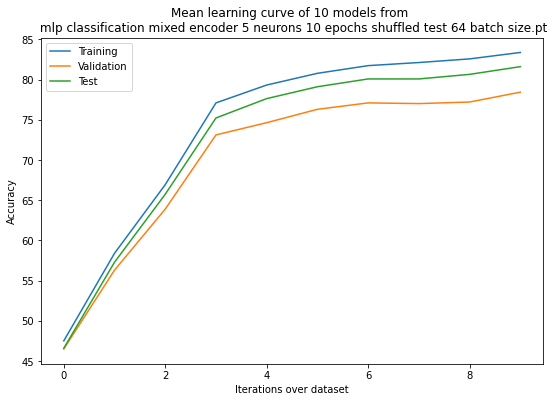

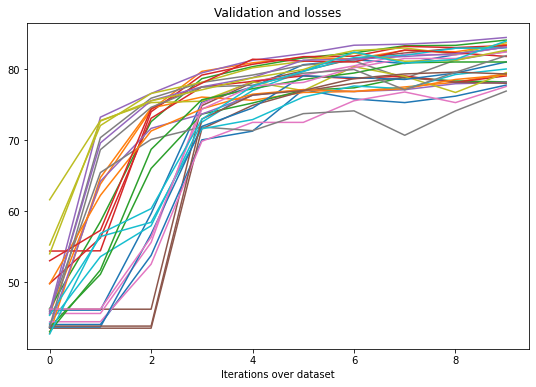

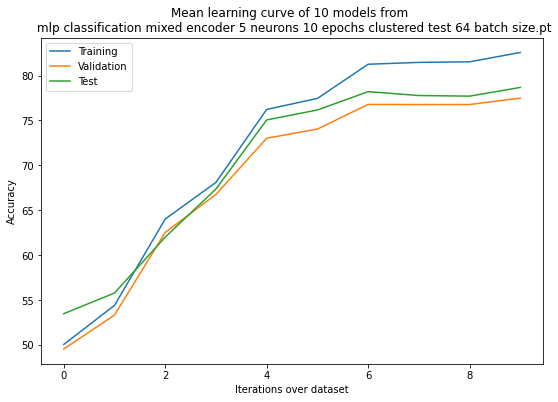

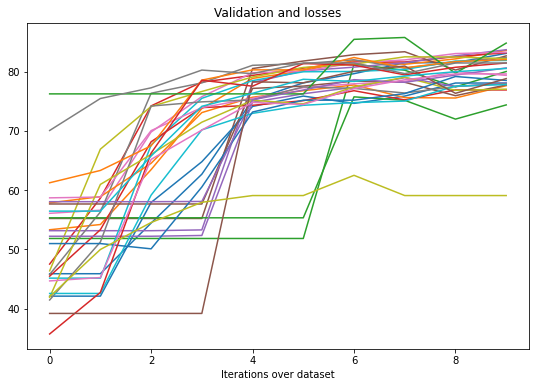

In [15]:
# models_path = "/home/daqop/Desktop/M2/Internship/python/trained_models/"
# models_path = "/home/daqop/mountpoint_snellius/3D-Vac/src/5_train_models/CNN/I/reg/seq/trained_models/"
models_path = "/home/daqop/train_branch_3D_Vac/src/5_train_models/CNN/I/classification/seq/trained_models/"
model_names = {
    "shuffled": "mlp_classification_mixed_encoder_5_neurons_10_epochs_shuffled_test_64_batch_size.pt",
    "clustered": "mlp_classification_mixed_encoder_5_neurons_10_epochs_clustered_test_64_batch_size.pt",
    # "dtu_clustered": "mlp_classification_mixed_encoder_1000_neurons_200_epochs_clustered_dtu_64_batch_size.pt",
}
shuffled_xval, shuffled_a = load_model(models_path + model_names["shuffled"], plot=True)
clustered_xval, clustered_a = load_model(models_path + model_names["clustered"], plot=True)
# clustered_dtu_xval, clustered_dtu_a = load_model(models_path + model_names["dtu_clustered"], plot=True)
s_tpr, s_fnr, s_tnr, s_fpr, s_nr, s_pr, s_accuracy = get_rates(shuffled_xval, shuffled_a)
c_tpr, c_fnr, c_tnr, c_fpr, c_nr, c_pr, c_accuracy = get_rates(clustered_xval, clustered_a)
# cd_tpr, cd_fnr, cd_tnr, cd_fpr, cd_nr, cd_pr, cd_accuracy = get_rates(clustered_dtu_xval, clustered_dtu_a)

In [16]:
print("###ACCURACIES###")
print("Shuffled accuracy:", s_accuracy.mean())
print("Shuffled accuracy std:", s_accuracy.std())
print("PAM 250 clustered Accuracy:", c_accuracy.mean())
print("PAM 250 clustered Accuracy std:", c_accuracy.std())
print("DTU clustered Accuracy:", cd_accuracy.mean())
print("DTU clustered Accuracy std:", cd_accuracy.std())

print("###PPV###")
print("Shuffled PPV:", s_tpr.mean())
print("PAM 250 clustered PPV:", c_tpr.mean())
print("DTU clustered PPV:", cd_tpr.mean())

###ACCURACIES###
Shuffled accuracy: tensor(0.8149)
Shuffled accuracy std: tensor(0.0152)
PAM 250 clustered Accuracy: tensor(0.7865)
PAM 250 clustered Accuracy std: tensor(0.0716)


NameError: name 'cd_accuracy' is not defined